In [19]:
!nvidia-smi

Wed Apr  9 14:35:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:42:00.0 Off |                    0 |
| N/A   35C    P0             40W /  250W |   16615MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
!pip install --upgrade transformers accelerate datasets optimum peft auto-gptq bitsandbytes scikit-learn torch matplotlib tqdm --quiet
!pip install flash-attn --no-build-isolation --quiet # for qwen2, newer nvidia gpus i.e. ampere and above

In [425]:
import os
import pandas as pd
import torch as t
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GPTQConfig, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay #,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import gc # garbage collector interface
import pprint
from typing import List, Tuple, Dict, Optional
from tqdm import tqdm
import math
from dataclasses import dataclass # for HallucinationMetrics class, currently unused

# --- Configuration ---
MODEL_NAME = 'Qwen/Qwen2.5-7B-Instruct' # try different models later
DATASET_NAME = 'UTAustin-AIHealth/MedHallu'
DATASET_CONFIG = 'pqa_labeled'
BATCH_SIZE = 8
MAX_SAMPLES = 1000
QUANTIZATION_MODE = '4bit_bnb' #'8bit_bnb' #'uncompressed'
EXPERIMENT_NAME = f'{MODEL_NAME.lower()}_{QUANTIZATION_MODE.lower()}_{DATASET_CONFIG.lower()}'

# --- Load Dataset ---
print(f'Loading {DATASET_NAME} dataset ({DATASET_CONFIG})...')
ds = load_dataset(DATASET_NAME, DATASET_CONFIG)
dataset = ds['train'] # use train split which has 1k labelled samples

if MAX_SAMPLES is not None:
    print(f'Limiting dataset to {MAX_SAMPLES} samples for testing.')
    dataset = dataset.select(range(MAX_SAMPLES)) # for N rows, there are 2*N answers for hallucination-detection LLM to classify (1 gt, 1 hallucinated answers)

# --- Setup Model and Tokenizer
print(f'Loading tokenizer for {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, padding_side="left") # was getting an error when trying to run inference on inputs with default padding_side = right
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # set pad token for batching if not present

# --- Quantization Setup --- need to test this, and clean it up (^^ゞ
print(f'Setting up {MODEL_NAME} with quantization: {QUANTIZATION_MODE}...')

# get quantization config
quantization_config = None
if QUANTIZATION_MODE == '8bit_bnb': #bnb is convenient, good for NVIDIA GPU ; doesn't work elsewere
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
elif QUANTIZATION_MODE == '4bit_bnb':
    quantization_config = BitsAndBytesConfig(load_in_4bit=True,)
elif QUANTIZATION_MODE == '4bit_torchao':
    quant_config = Int4WeightOnlyConfig(group_size=128)
    quantization_config = TorchAoConfig(quant_type=quant_config)
elif QUANTIZATION_MODE == '8bit_torchao':
    pass
elif QUANTIZATION_MODE == 'gguf': # widely used, CPU, mobile
    # QWEN : General Model
    qwen = {
        model: "bartowski/Qwen2.5-7B-Instruct-GGUF", #
        gguf_fmts: {
            '8b': "Qwen2.5-7B-Instruct-Q8_0.gguf", # downloadable gguf filename available online
            '6b': "",
            '5b': "",
            '4b': "",
            '3b': "",
            '2b': ""
        }
    }

    # LLAMA3-Med42-8B Model : Medical Fine Tuned
    llama3_med = {
        model: "mradermacher/Llama3-Med42-8B-GGUF",
        gguf_fmats: {
            '8b': "",
        }
    }

# these guys require a calibration dataset -- ignoring them due to project time constraints
elif QUANTIZATION_MODE == '4bit_gptq':
    quantization_config = GPTQConfig(bits=4, dataset='c4', tokenizer=tokenizer) # is the dataset ok to use? would it be better to use a medical dataset?
elif QUANTIZATION_MODE == 'awq':
    pass


# hyperparameters
model_kwargs = {
    "quantization_config": quantization_config,
    "device_map": "auto",
    "attn_implementation": "eager", #"flash_attention_2", ; doesn't work on Volta GPU (old) ; so ignoring this for now ; may revisit if I need to speed up inference
    "torch_dtype": t.float16, # torch.bfloat16 for ampere, maybe not best on older Volta GPU
    "trust_remote_code": True
}
if QUANTIZATION_MODE == 'uncompressed':
    model_kwargs.pop("quantization_config")
elif QUANTIZATION_MODE == "4bit_gptq":
    model_kwargs.pop("torch_dtype")

# --- Instantiate Model ---
model = None
try:
    if 'model' in globals():
        print("Deleting existing global 'model' variable.")
        del globals()['model']
    if 'classifier' in globals():
        print("Deleting existing bloal 'classifier' variable.")
        del globals()['classifier']
    gc.collect()
    t.cuda.empty_cache()
    print(f"Loading model: {MODEL_NAME}")
    
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)
    print(f"{MODEL_NAME} model loaded successfully!")

except Exception as e:
    print(f"Failed to load model: {e}")
    raise e

# --- Setup Pipeline ---
classifier = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# --- Define Prompting Function ---
# used in the paper
original_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question and an
answer, your objective is to determine if the provided answer contains non-factual or hallucinated information. You SHOULD give your judgement based
on the following hallucination types and the world knowledge.

You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual and '1' if the answer is hallucinated.
You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual and '1' if the answer is hallucinated. No letter or word, just the integer value.
"""

# modification on our part to allow model to refrain from making a classification if it is not sure
not_sure_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question, an
answer, and relevant World Knowledge, determine if the provided answer is factual or contains hallucinated information based on the knowledge provided and established medical facts.

- If the answer is factual and consistent with world knowledge, return '0'.
- If the answer contains non-factual, hallucinated, or contradictory information based on the knowledge provided or established medical facts (e.g., Misinterpretation, Incomplete Info, Mechanism Misattribution, Fabrication), return '1'.
- If you are genuinely uncertain or cannot make a definitive judgement based on the provided context and your medical knowledge, return '2'.

Do not return anything else, just the integer value.

Return '0' for factual, '1' for hallucinated, '2' for not sure.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, '2' if not sure. No letter or word, just the integer value.
"""

not_sure_system_prompt2 = """
You are an AI judge with extensive knowledge in the field of medicine. I want you act as an answer judge. Given World Knowledge, a Question, and an Answer:
- Return '0' if the Answer is factual based on the Knowledge and your understanding of medicine.
- Return '1' if the Answer is hallucinated based on the Knowledge and/or your understanding of medicine.
- Return '2' if you are unsure.

You SHOULD give your judgement based on the following hallucination types and the world knowledge.
You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual, '1' if the answer is hallucinated, '2' if you are unsure.

Output only the single digit 0, 1, or 2 and nothing else.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, or '2'. No letter or word, just the integer value.
"""

def format_prompt_chatml(knowledge: str, question: str, answer: str, prompt_style="original") -> List[dict]:
    """Put together world knowledge, a medical question, and a medical answer together in a prompt according to requested prompt_style"""
    
    few_shot_not_sure_user_content = f"""
    World Knowledge: [Example Knowledge Snippet]
    Question: [Example Question]
    Answer: [Example Factual Answer]
    Your Judgement: 0
    
    World Knowledge: [Example Knowledge Snippet 2]
    Question: [Example Question 2]
    Answer: [Example Hallucinated Answer]
    Your Judgement: 1
    
    World Knowledge: [Example Knowledge Snippet 3 - where answer might be ambiguous or knowledge insufficient]
    Question: [Example Question 3]
    Answer: [Example Ambiguous Answer or Answer unrelated to Knowledge]
    Your Judgement: 2
    
    --- Now your turn ---
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}
    
    Return just '0' (factual), '1' (hallucinated), or '2' (not sure).
    Your Judgement:"""

    original_user_content = f""""
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}

    Return just an integer value, '0' if the answer is factual, and '1' if the answer is hallucinated. No letter or word, just the integer value.
    
    Your Judgement:"""

    user_prompt = None
    if prompt_style == "few_shot_not_sure":
        user_prompt = few_shot_not_sure_user_content
    elif prompt_style == "original":
        user_prompt = original_user_content
    
    messages = [
        {"role": "system", "content": original_system_prompt.strip()}, # remove leading/trailing whitespaces with .strip()
        {"role": "user", "content": original_user_content.strip()} # original meaning, from the MedHallu paper
    ]
    return messages

# --- Prompt Creation ---
def prepare_prompts(dataset):
    all_prompts = [] # all string prompts
    #all_ground_truths = [] # corresponding labels for each prompt (0: truth, 1: hallucinated)
    
    print("Preparing prompts")
    for i, row in enumerate(dataset):
        knowledge = row["Knowledge"]
        question = row["Question"]
        hallucinated_answer = row["Hallucinated Answer"]
        ground_truth_answer = row["Ground Truth"]
    
        # create prompts for hallucinated and ground truth answers
        prompt_hallucinated = format_prompt_chatml(knowledge, question, hallucinated_answer)
        prompt_truth = format_prompt_chatml(knowledge, question, ground_truth_answer)
    
        all_prompts.append(prompt_hallucinated)
        #all_ground_truths.append(1)
        all_prompts.append(prompt_truth)
        #all_ground_truths.append(0)
    print("Prompts are prepared.")
    return all_prompts

all_prompts = prepare_prompts(dataset)

Loading UTAustin-AIHealth/MedHallu dataset (pqa_labeled)...
Limiting dataset to 1000 samples for testing.
Loading tokenizer for Qwen/Qwen2.5-7B-Instruct...
Setting up Qwen/Qwen2.5-7B-Instruct with quantization: 4bit_bnb...
Deleting existing global 'model' variable.
Deleting existing bloal 'classifier' variable.
Loading model: Qwen/Qwen2.5-7B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Qwen/Qwen2.5-7B-Instruct model loaded successfully!
Preparing prompts
Prompts are prepared.


In [426]:
# -- Inference ---
# during inference, how much GPU RAM is used? can we measure peak/avg/min RAM usage? i.e. as in work by Ji Lin (MIT HAN Lab) on fitting CNNs in tiny MCUs
def classify_med_answers(prompts):
    print(f"Starting batch inference on {len(prompts)} prompts...")
    outputs = []
    num_batches=math.ceil(len(prompts) / BATCH_SIZE)
    with t.no_grad():
        # show inference progress bar with tqdm
        for batch_idx in tqdm(range(num_batches), desc="Classifying Batches", unit="batch"):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE,len(all_prompts))
            batch_prompts = prompts[start_idx:end_idx]
            batch_output = classifier(batch_prompts,
                                      #batch_size=BATCH_SIZE # redundant
                                      max_new_tokens=3, # should this be a hyperparam we include in a cfg file?
                                      pad_token_id=tokenizer.pad_token_id,
                                      eos_token_id=tokenizer.eos_token_id,
                                      do_sample=False,
                                      repetition_penalty=1.2) 
            outputs.extend(batch_output)
    
        # all at once
        #outputs = classifier(
        #    all_prompts,
        #    max_new_tokens=3,
        #    batch_size=BATCH_SIZE,
        #    pad_token_id=tokenizer.pad_token_id,
        #    eos_token_id=tokenizer.eos_token_id,
        #    do_sample=False,
        #    repetition_penalty=1.2
        #)
    print("Inference complete.")
    return outputs

gc.collect()
t.cuda.empty_cache()
t.cuda.reset_peak_memory_stats()
outputs = classify_med_answers(all_prompts)

Starting batch inference on 2000 prompts...


/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/venv/main/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into 

Inference complete.


In [427]:
## --- Profiling GPU Usage ---
peak_memory_bytes = t.cuda.max_memory_allocated()
peak_memory_gb = peak_memory_bytes / (2**30) # 2^30B in one GB
print(f"Peak GPU Memory Allocated: {peak_memory_gb} GB")

Peak GPU Memory Allocated: 6.252573013305664 GB


In [428]:
print(t.cuda.memory_allocated() / 2**30)
print(t.cuda.max_memory_allocated() / 2**30)
print(t.cuda.memory_reserved() / 2**30)

5.463407039642334
6.252573013305664
14.37890625


In [429]:
# -- Process LLM Outputs -- 
predictions = []
raw_outputs = []

def parse_prediction(generated_text):
    """Extract the '0' or '1' from generated text, in case model does not listen to instructions and adds other tokens"""
    text = generated_text.strip()
    text_start = text[-10:]
    #print("text start: ", text_start)
    if '0' in text_start:
        return 0
    elif '1' in text_start:
        return 1
    elif '2' in text_start:
        return 2
    else:
        #print(f"Could not parse '0' or '1' from model output: {text}")
        return -1

def extract_binary_predictions(outputs):
    """iterate through each output, filter out original prompt, extract binary prediction, and append to lists for predictions and raw model outputs"""
    predictions = []
    raw_outputs = []
    print("Processing Results.")
    for i, output in enumerate(outputs):
        model_response = None
        try:
            full_chat = output[0]['generated_text'] # this INCLUDES the prompt ; we only want newly generated text
            assistant_response_dict = full_chat[-1] # full_chat[0]: system, full_chat[1]: user, full_chat[2]: assistant
            #print(assistant_response_dict)
            model_response = None
            if assistant_response_dict['role'] == 'assistant':
                model_response = assistant_response_dict['content']
        except:
            pass
        
        pred = parse_prediction(model_response)
        predictions.append(pred)
        raw_outputs.append(model_response) # store the raw '!!!!!' or '0' or '1'
    print("Results Processed.")
    return predictions, raw_outputs

predictions, raw_outputs = extract_binary_predictions(outputs)

Processing Results.
Results Processed.


In [430]:
# --- Compute Metrics (fnr, tpr, acc, prec, rec, f1, abstention rate) ---

# something to think about.. what is the goal here? if we have an assistant AI answering medical questions,
# if we verify answers with an LLM-checker, we'd want that LLM-checker to be compact so deployment is easy
# and we'd want it to be good and identifying the hallucinations so we can weed them out
# and protect relevant stakeholders (i.e. doctors, laypeople) from misleading information
# for developers, if we can get insights into types of answers/hallucinations that compressed models work best/worst with
# this could help them inform strategies for deploying an LLM-checker
# i.e. "for our use case, it's most important to avoid B type hallucinations, or that's the most commong type that 
# could come up in our work ; we have X physical constraints for the device we have access to"
# so for them, perhaps we'd go with 1B awq_4bit quantized model. granted, model's move fast i.e.
# what's new today is old tomorrow ; so at the very least, we'd be contributed a codebase that
# developers can use to easily swap in different models, to quickly test what's best for their use case

@dataclass
class HallucinationMetrics:
    difficulty_metrics: Dict[str, float]
    category_metrics: Dict[str, float]
    overall_metrics: Dict[str, float]
    abstention_analysis: Dict[str, float]

def get_hallucination_info(info_type: str, dataset):
    """
    construct lists for the type and difficulty of hallucinated answers in all_prompts
    all_ground_truths:        [    1,     0,        1,    0, ...]
    hallucination_difficulty: ["easy", None, "medium", None, ...]
    """
    hallucination_difficulty = [None]*dataset.num_rows*2
    hallucination_category = [None]*dataset.num_rows*2
    for idx, val in enumerate(all_ground_truths):
        if val == 1:
            hallucination_difficulty[idx] = dataset['Difficulty Level'][idx//2]
            hallucination_category[idx] = dataset['Category of Hallucination'][idx//2]

    if info_type == "difficulty":
        return hallucination_difficulty
    elif info_type == "category":
        return hallucination_category

# --- Assemble final results ---
# example
# all_ground_truths:              [    1,     0,     1,     0]
# raw_gt_pred_pairs:             [(1,0), (0,-1), (1,1), (0,0)]
# raw_hallucination_difficulty: ["hard",   None,"easy",  None]
# raw_hallucination_category:  [   "A",    None,   "B",  None]

# valid_idxs: [0,2,3] (explicit) ; [1, 0, 1, 1] (boolean mask) ; we'll go with the explicit version
# gt_pred_pairs:         [(1,0),  (1,1),   (0,0)]
# valid_hal_difficulty: ["hard", "easy",   None]
# valid_hal_category:  [    "A",   "B",   None]

all_ground_truths = [1,0] * dataset.num_rows # in prepare_prompts(), we alternate between adding prompts with hallucination and gt answers
raw_gt_pred_pairs = t.tensor(list(zip(all_ground_truths, predictions))) # tensor allows for easy selection from a list of desired idxs
raw_hallucination_difficulty = get_hallucination_info("difficulty", dataset) # can't convert to tensor b/c has strings
raw_hallucination_category = get_hallucination_info("category", dataset)

#raw_results_df = pd.DataFrame({
#    'gt': all_ground_truths,
#    'predictions': predictions,
#    'difficulty': raw_hallucination_difficulty,
#    'category': raw_hallucination_category
#})
#raw_results_df['is_valid'] = raw_results_df[raw_results_df['predictions'] != -1]

valid_idxs = [idx for idx, (gt,pred) in enumerate(raw_gt_pred_pairs) if pred != -1] # explicit [0, 2, 3, 4, 7, 110]
gt_pred_pairs = raw_gt_pred_pairs[valid_idxs] #filter_invalid_pairs(raw_gt_pred_pairs)
valid_hal_difficulty = [raw_hallucination_difficulty[valid_idx] for valid_idx in valid_idxs]
valid_hal_category = [raw_hallucination_category[valid_idx] for valid_idx in valid_idxs]

valid_df = pd.DataFrame({
    'gt': [gt for (gt,pred) in gt_pred_pairs],
    'predictions': [pred for (gt,pred) in gt_pred_pairs],
    'difficulty': valid_hal_difficulty,
    'category': valid_hal_category
})

def compute_confusion_matrix_vals(gt_pred_pairs: list[tuple[int,int]]):
    """compute and return TP, FP, TN, FN from a list of (ground truth, prediction) pairs"""
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # used for analysis later
    TP_idxs = []
    FP_idxs = []
    TN_idxs = []
    FN_idxs = []
    
    for idx, (gt,pred) in enumerate(gt_pred_pairs):
        if pred == 1 and gt == 1:
            TP += 1
            TP_idxs.append(idx)
        elif pred == 1 and gt == 0:
            FP += 1
            FP_idxs.append(idx)
        elif pred == 0 and gt == 0:
            TN += 1
            TN_idxs.append(idx)
        elif pred == 0 and gt == 1:
            FN += 1
            FN_idxs.append(idx)
    return TP, FP, TN, FN, TP_idxs, FP_idxs, TN_idxs, FN_idxs
    
# --- Calculate Metrics ---
accuracy = None
precision = None
recall = None
f1 = None
abstention_rate = None
cm = None

if len(gt_pred_pairs) > 0:
    TP, FP, TN, FN, TP_idxs, FP_idxs, TN_idxs, FN_idxs = compute_confusion_matrix_vals(gt_pred_pairs)
    cm = np.array([[TN, FP], [FN, TP]])
    #cm = confusion_matrix(valid_gts, valid_preds, labels=[0,1])

    # what proportion of answers did the LLM NOT classify?
    total_valid_preds = len(gt_pred_pairs)
    invalid_count = len(raw_gt_pred_pairs) - total_valid_preds
    abstention_rate = invalid_count / len(raw_gt_pred_pairs)

    # what does tpr, fpr look like for different hallucination categories, difficulties?
    # get counts
    fn_difficulty_counts = valid_df.iloc[FN_idxs]['difficulty'].value_counts() # measure of error; type II error (minimize!!)
    tp_difficulty_counts = valid_df.iloc[TP_idxs]['difficulty'].value_counts() # success measure; sensitivity (a.k.a recall) (maximize!!)
    fn_category_counts = valid_df.iloc[FN_idxs]['category'].value_counts()
    tp_category_counts = valid_df.iloc[TP_idxs]['category'].value_counts()

    # plot fnr
    fnr_difficulty = fn_difficulty_counts / (fn_difficulty_counts + tp_difficulty_counts)
    fnr_category = fn_category_counts / (fn_category_counts + tp_category_counts)

    # plot tpr
    tpr_difficulty = tp_difficulty_counts / (tp_difficulty_counts + fn_difficulty_counts)
    tpr_category = tp_category_counts / (tp_category_counts.add(fn_category_counts, fill_value=0))
    
    # overall metrics: accuracy, precision, recall, f1 score
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    valid_gts = [gt for (gt,pred) in gt_pred_pairs]
    valid_preds = [pred for (gt,pred) in gt_pred_pairs]
    precision, recall, f1, support = precision_recall_fscore_support(
        valid_gts, valid_preds, average='binary', pos_label=1, zero_division=0
    )
else:
    print("No valid predictions were made, skipping metric calculations.")

## Generate Hallucination Analysis Plots

difficulty
hard      0.232843
medium    0.147799
easy      0.087591
Name: count, dtype: float64


<Axes: title={'center': 'False Negative (miss) rate, organized by hallucination difficulty'}, xlabel='difficulty'>

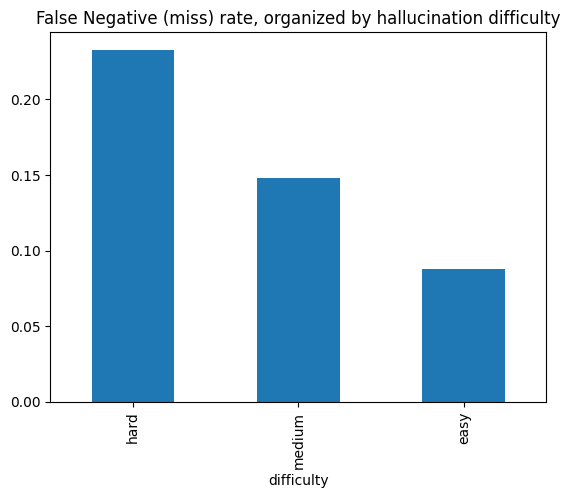

In [431]:
# --- Plot hallucination FN (miss) rate, organized by difficulty level of hallucinated answers
fnr_difficulty = fn_difficulty_counts / (fn_difficulty_counts + tp_difficulty_counts)
print(fnr_difficulty)
#plt.bar(fnr_difficulty.index, fnr_difficulty)
fnr_difficulty.plot(title="False Negative (miss) rate, organized by hallucination difficulty", kind='bar')

category
Incomplete Information                     0.254717
Mechanism and Pathway Misattribution       0.030303
Methodological and Evidence Fabrication    0.000000
Misinterpretation of #Question#            0.147606
Name: count, dtype: float64
category
Misinterpretation of #Question#         111
Incomplete Information                   54
Mechanism and Pathway Misattribution      1
Name: count, dtype: int64


<Axes: title={'center': 'False Negative (miss) rate organized by category'}, xlabel='category'>

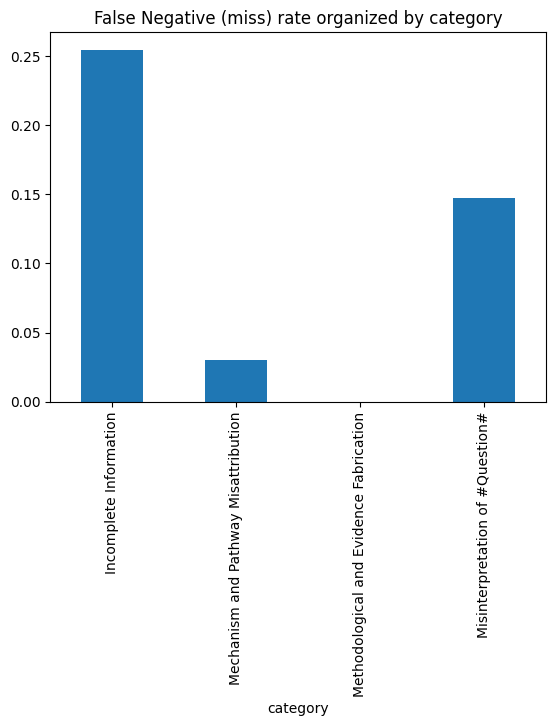

In [432]:
# we are interested in the false negative rate ; what is the LLM missing? ; this is the complement of tpr ; what is the LLM succeeding on?
# --- Plot FN (miss) rate, by category ---
fn_category_counts = valid_df.iloc[FN_idxs]['category'].value_counts()
tp_category_counts = valid_df.iloc[TP_idxs]['category'].value_counts()
fnr_category = fn_category_counts.divide((fn_category_counts.add(tp_category_counts,fill_value=0)),fill_value=0)
print(fnr_category)
print(fn_category_counts)
fnr_category.plot(title="False Negative (miss) rate organized by category",kind='bar')

Text(0, 0.5, 'False Negative Rate')

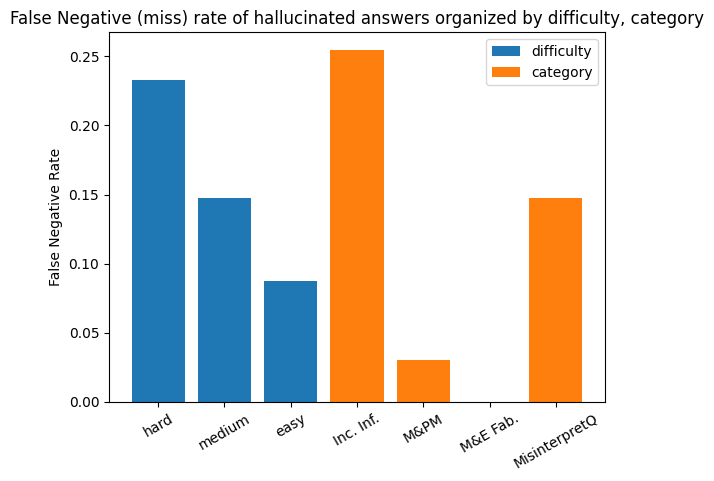

In [433]:
# --- Combined FNR Plot ---
# fnr_difficulty, fnr_category
rename_hallucination_cat = {'Incomplete Information': 'Inc. Inf.',
                    'Mechanism and Pathway Misattribution': 'M&PM',
                    'Misinterpretation of #Question#': 'MisinterpretQ',
                    'Methodological and Evidence Fabrication': 'M&E Fab.'}
plt.bar(fnr_difficulty.index, fnr_difficulty)
plt.bar([rename_hallucination_cat[x] for x in fnr_category.index], fnr_category)
plt.xticks(rotation=30)
plt.legend(['difficulty', 'category'])
plt.title("False Negative (miss) rate of hallucinated answers organized by difficulty, category")
plt.ylabel('False Negative Rate')
#plt.bar(fnr_category.index, fnr_category)

Text(0.5, 1.0, 'True Positive (hit) rate for hallucinated answers organized by difficulty')

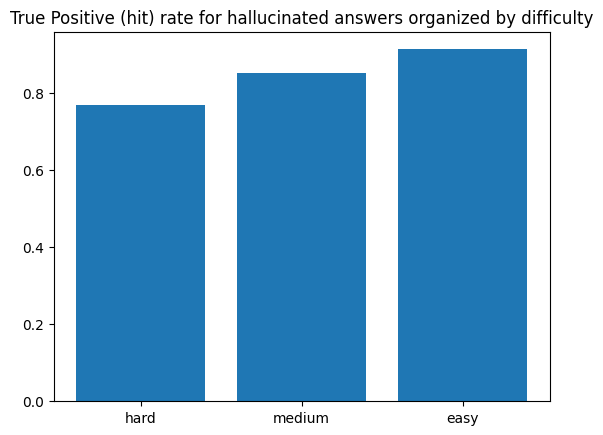

In [434]:
tpr_difficulty = tp_difficulty_counts / (tp_difficulty_counts + fn_difficulty_counts)
tpr_category = tp_category_counts / (tp_category_counts.add(fn_category_counts, fill_value=0)) # avoid NaN ; fn_category_counts didn't come across a category

# --- Plot TPR by Difficulty ---
plt.bar(tpr_difficulty.index, tpr_difficulty)
plt.title('True Positive (hit) rate for hallucinated answers organized by difficulty')

In [435]:
print(tp_category_counts)
print(fn_category_counts)
# notice how for the fn_category_counts, one of the categories is missing ; for that category we had no false negatives ;
# beware of NaNs showing up later because of this

category
Misinterpretation of #Question#            641
Incomplete Information                     158
Mechanism and Pathway Misattribution        32
Methodological and Evidence Fabrication      3
Name: count, dtype: int64
category
Misinterpretation of #Question#         111
Incomplete Information                   54
Mechanism and Pathway Misattribution      1
Name: count, dtype: int64


category
Incomplete Information                     0.745283
Mechanism and Pathway Misattribution       0.969697
Methodological and Evidence Fabrication    1.000000
Misinterpretation of #Question#            0.852394
Name: count, dtype: float64


Text(0, 0.5, 'true positive rate')

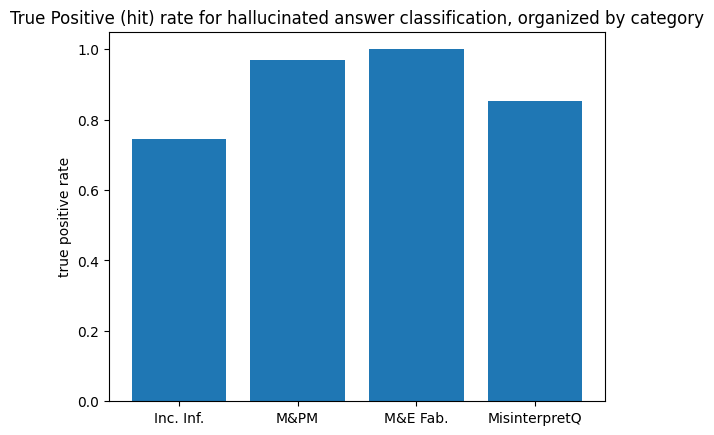

In [436]:
# --- Plot TPR Category ---
print(tpr_category)
plt.bar([rename_hallucination_cat[x] for x in tpr_category.index], tpr_category)
plt.title('True Positive (hit) rate for hallucinated answer classification, organized by category')
plt.ylabel('true positive rate')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'hard'),
  Text(1, 0, 'medium'),
  Text(2, 0, 'easy'),
  Text(3, 0, 'Inc. Inf.'),
  Text(4, 0, 'M&PM'),
  Text(5, 0, 'M&E Fab.'),
  Text(6, 0, 'MisinterpretQ')])

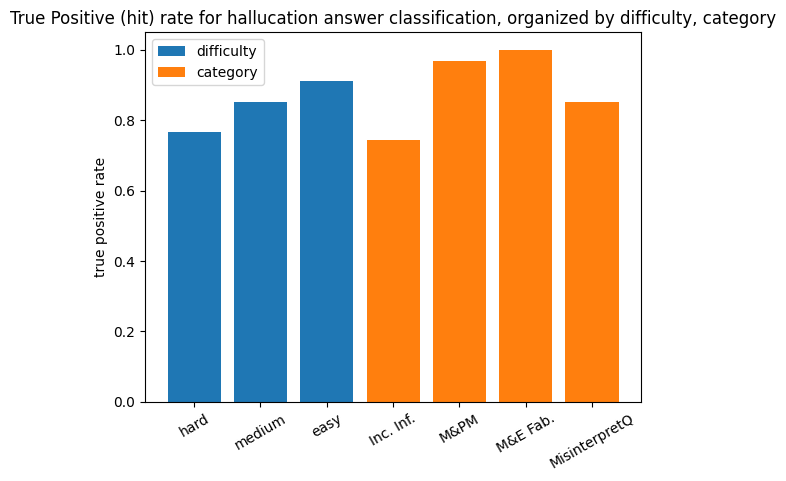

In [437]:
# --- Combined TPR Plot ---
plt.bar(tpr_difficulty.index, tpr_difficulty)
plt.bar([rename_hallucination_cat[x] for x in tpr_category.index], tpr_category)
plt.title('True Positive (hit) rate for hallucation answer classification, organized by difficulty, category')
plt.legend(['difficulty', 'category'])
plt.ylabel('true positive rate')
plt.xticks(rotation=30)

### (alt. way of) Generating Hallucination Analysis Plots [deprecated]

In [438]:
# critical for hallucinations: TPs (catch all hals) and FNs (avoid missing any hals)
# TPR <-> FNR are linked ; a higher TPR => a lower FNR
# TPR : TP / (TP + FN)
# FNR : FN / (TP + FN) = 1 - TPR
# => so, recording both TP and FN may be redundant, as info about one tells us about the other
# => different convention in different fields; i.e. in medicine focus is on FNR (alpha error),
# whereas in information retrieval, focus is on TPR (recall), though both are complementary measures.
# in our case, because the data-domain is very closely linked with medicine, we choose to 
# focus on error rates
print("# prior hallucination counts by difficulty")
print(f"{raw_df['hallucination_difficulty'].value_counts()}\n")
print("FN counts")
print(f"{valid_df.iloc[FN_idxs]['difficulty'].value_counts()}\n")
print("TP counts")
print(f"{valid_df.iloc[TP_idxs]['difficulty'].value_counts()}\n")

print("# prior hallucination counts by category")
print(f"{raw_df['hallucination_category'].value_counts()}\n")
print("FN counts")
print(f"{valid_df.iloc[FN_idxs]['category'].value_counts()}\n")
print("TP counts")
print(f"{valid_df.iloc[TP_idxs]['category'].value_counts()}\n")

# prior hallucination counts by difficulty
hallucination_difficulty
hard      408
medium    318
easy      274
Name: count, dtype: int64

FN counts
difficulty
hard      95
medium    47
easy      24
Name: count, dtype: int64

TP counts
difficulty
hard      313
medium    271
easy      250
Name: count, dtype: int64

# prior hallucination counts by category
hallucination_category
Misinterpretation of #Question#            752
Incomplete Information                     212
Mechanism and Pathway Misattribution        33
Methodological and Evidence Fabrication      3
Name: count, dtype: int64

FN counts
category
Misinterpretation of #Question#         111
Incomplete Information                   54
Mechanism and Pathway Misattribution      1
Name: count, dtype: int64

TP counts
category
Misinterpretation of #Question#            641
Incomplete Information                     158
Mechanism and Pathway Misattribution        32
Methodological and Evidence Fabrication      3
Name: count, dtype: in

In [439]:
# --- Alternate method (the first) we used to do hallucination classification analysis ---
# --- we may deprecate this, because it seems more complicated than just using pandas df.value_counts()
fn_difficulty_group = valid_df.iloc[FN_idxs][['gt', 'difficulty']].groupby("difficulty")['gt'].sum() # same result as value_counts()?
fn_category_group = valid_df.iloc[FN_idxs][['gt', 'category']].groupby("category")['gt'].sum()
tp_difficulty_group = valid_df.iloc[TP_idxs][['gt', 'difficulty']].groupby("difficulty")['gt'].sum()
tp_category_group = valid_df.iloc[TP_idxs][['gt', 'category']].groupby("category")['gt'].sum()
hal_tp_analysis = {'tp_difficulty': tp_difficulty_group.to_dict(), 'tp_category': tp_category_group.to_dict()}
hal_fn_analysis = {'fn_difficulty': fn_difficulty_group.to_dict(), 'fn_category': fn_category_group.to_dict()}

In [440]:
pprint.pp(hal_tp_analysis) # add to results_dict?
pprint.pp(hal_fn_analysis)

{'tp_difficulty': {'easy': tensor(250),
                   'hard': tensor(313),
                   'medium': tensor(271)},
 'tp_category': {'Incomplete Information': tensor(158),
                 'Mechanism and Pathway Misattribution': tensor(32),
                 'Methodological and Evidence Fabrication': tensor(3),
                 'Misinterpretation of #Question#': tensor(641)}}
{'fn_difficulty': {'easy': tensor(24),
                   'hard': tensor(95),
                   'medium': tensor(47)},
 'fn_category': {'Incomplete Information': tensor(54),
                 'Mechanism and Pathway Misattribution': tensor(1),
                 'Misinterpretation of #Question#': tensor(111)}}


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'easy'),
  Text(1, 0, 'hard'),
  Text(2, 0, 'medium'),
  Text(3, 0, 'Inc. Inf.'),
  Text(4, 0, 'M&PM'),
  Text(5, 0, 'MisinterpretQ')])

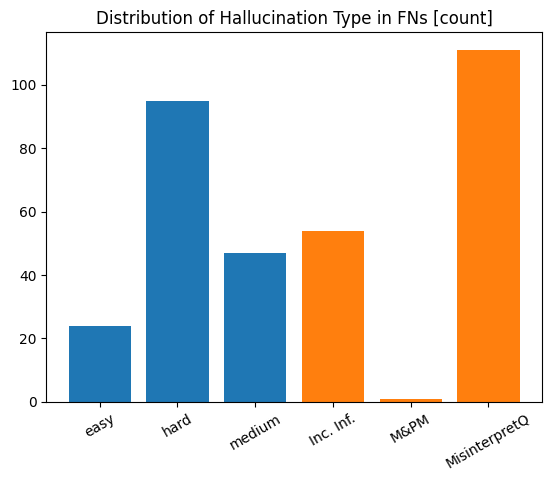

In [441]:
# --- Plot FN Distributions (counts) ---
plt.title('Distribution of Hallucination Type in FNs [count]')
plt.bar(hal_fn_analysis['fn_difficulty'].keys(), hal_fn_analysis['fn_difficulty'].values())
#plt.show()
rename_hal_types = {'Incomplete Information': 'Inc. Inf.',
                    'Mechanism and Pathway Misattribution': 'M&PM',
                    'Misinterpretation of #Question#': 'MisinterpretQ',
                    'Methodological and Evidence Fabrication': 'M&E Fab.'}
plt.bar([rename_hal_types[k] for k in hal_fn_analysis['fn_category'].keys()],
        hal_fn_analysis['fn_category'].values())
plt.xticks(rotation=30)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'easy'),
  Text(1, 0, 'hard'),
  Text(2, 0, 'medium'),
  Text(3, 0, 'Inc. Inf.'),
  Text(4, 0, 'M&PM'),
  Text(5, 0, 'M&E Fab.'),
  Text(6, 0, 'MisinterpretQ')])

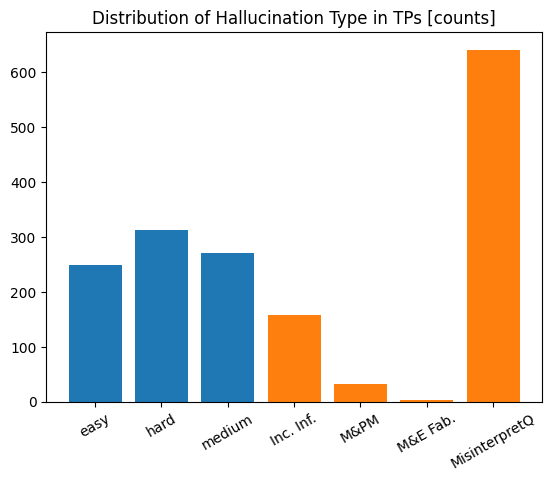

In [442]:
# --- Plot TP Distributions (counts) ---
plt.title('Distribution of Hallucination Type in TPs [counts]')
plt.bar(hal_tp_analysis['tp_difficulty'].keys(), hal_tp_analysis['tp_difficulty'].values())
#plt.show()
rename_hal_types = {'Incomplete Information': 'Inc. Inf.',
                    'Mechanism and Pathway Misattribution': 'M&PM',
                    'Misinterpretation of #Question#': 'MisinterpretQ',
                    'Methodological and Evidence Fabrication': 'M&E Fab.'}
plt.bar([rename_hal_types[k] for k in hal_tp_analysis['tp_category'].keys()],
        hal_tp_analysis['tp_category'].values())
plt.xticks(rotation=30)

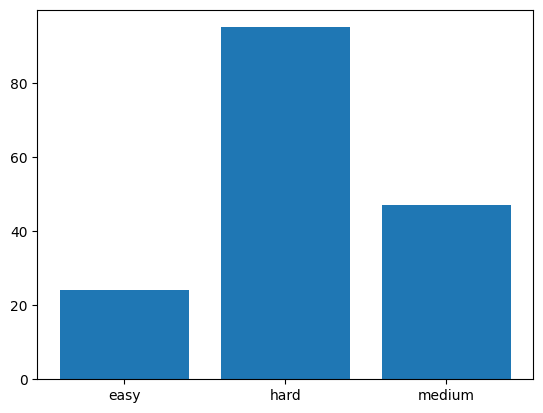

['Incomplete Information', 'Mechanism and Pathway Misattribution', 'Misinterpretation of #Question#']


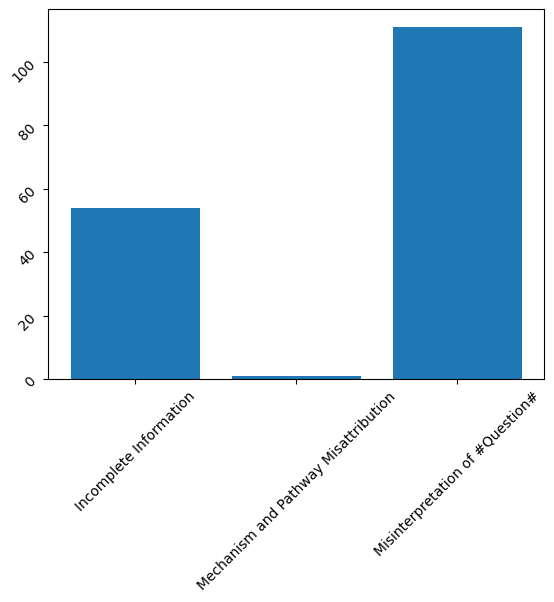

In [443]:
plt.bar(fn_difficulty_group.to_dict().keys(), fn_difficulty_group.to_dict().values())
plt.show()

fn_category_group = valid_df.iloc[FN_idxs][['gt', 'category']].groupby("category")['gt'].sum()
print(list(fn_category_group.to_dict().keys()))
fig, ax = plt.subplots()
ax.bar(fn_category_group.to_dict().keys(), fn_category_group.to_dict().values())
#plt.xticks(rotation=40)
ax.tick_params(rotation=45)
plt.show()
#fn_category_group.astype(float).plot(kind='bar')

In [444]:
valid_df.iloc[FN_idxs][['gt', 'category']].groupby("category")['gt'].sum()
#fn_category_group.astype(float).plot(kind='bar')

category
Incomplete Information                   tensor(54)
Mechanism and Pathway Misattribution      tensor(1)
Misinterpretation of #Question#         tensor(111)
Name: gt, dtype: object

In [445]:
# most important metric in hallucination detection in recall ; 
# false negatives are highly costly ; higher recall -> less FNs ; for all FNs we can look examine distribution of hallucination type/difficulty

## Save Results

Currently, experiment tracking consists of writing the whole results dictionary to a txt file. This way of tracking results may make lead to lots of time wasted in trying to analyze results after multiple experiments have been done (i.e. for different quant levels, quant methods, models). By then, the txt file may be too messy to work with.

**todo:** consider alternative method(s) of exp. tracking

In [446]:
import json

In [447]:
EXPERIMENT_NAME.split('/')[-1]

'qwen2.5-7b-instruct_4bit_bnb_pqa_labeled'

In [448]:
# --- Save Results ---
# can we write these results as a line in a text/csv/yaml file?
# is there a better way to track results i.e. incl exp name, use a config file, use tool(s) like Hydra, W&B?
EXPERIMENT_NAME = EXPERIMENT_NAME.split('/')[-1]
results = {
    'experiment_name': EXPERIMENT_NAME,
    'metrics': {
        'cm': cm.tolist(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall, 
        'f1': f1,
        'abstention_rate': abstention_rate, 
        'gpu_peak_memory_gb': peak_memory_gb,
        'fnr_difficulty': fnr_difficulty.to_dict(),
        'fnr_category': fnr_category.to_dict(),
        'tpr_difficulty': tpr_difficulty.to_dict(),
        'tpr_category': tpr_category.to_dict()
    }
}

def write_results_to_json(results: dict = results):
    out_file = f"results_{EXPERIMENT_NAME}.json"
    print(f"Saving results to {out_file}.")
    with open(out_file, 'w') as f:
        json.dump(results, f, indent=4)
    print("Save complete.")
    
def write_results_to_txt(results: dict = results):
    pprint.pp((results_df))
    with open('results.txt', 'w') as results_file:
        results_file.write(str(results_df))

write_results_to_json()

Saving results to results_qwen2.5-7b-instruct_4bit_bnb_pqa_labeled.json.
Save complete.


In [449]:
pd.Series(fnr_category.to_dict())

Incomplete Information                     0.254717
Mechanism and Pathway Misattribution       0.030303
Methodological and Evidence Fabrication    0.000000
Misinterpretation of #Question#            0.147606
dtype: float64

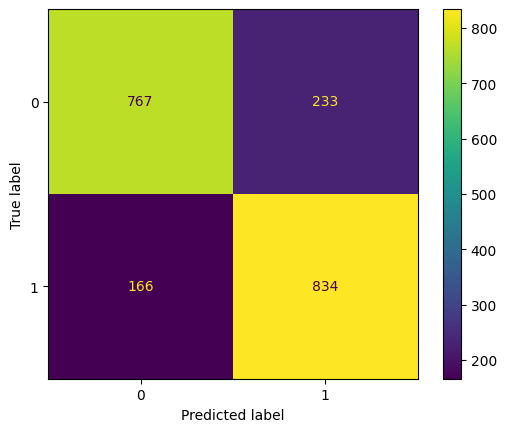

In [450]:
dp = ConfusionMatrixDisplay(cm)
dp.plot()
plt.show()

In [451]:
cm.tolist()

[[767, 233], [166, 834]]

In [452]:
t.tensor(list(zip(all_ground_truths, predictions))).shape

torch.Size([2000, 2])

In [453]:
tokenizer.encode('!')

[0]

## Tests

In [454]:
def check_dataset():
  print(ds['train'])
  i = 0
  for row in ds['train']:
    if i == 4:
      break
    question = row['Question']
    hallucinated_answer = row['Hallucinated Answer']
    ground_truth_answer = row['Ground Truth']
    hal_difficulty = row["Difficulty Level"]
    hal_category = row["Category of Hallucination"]
    print(hal_difficulty, hal_category)
    i += 1
check_dataset()

Dataset({
    features: ['Question', 'Knowledge', 'Ground Truth', 'Difficulty Level', 'Hallucinated Answer', 'Category of Hallucination'],
    num_rows: 1000
})
medium Mechanism and Pathway Misattribution
hard Incomplete Information
hard Misinterpretation of #Question#
easy Misinterpretation of #Question#


In [455]:
def test_confusion_matrix_calculation():
    # test 1
    test_gt_pred_pairs = [(1,1), (1,1), (1, 1), (0,1), (0,0), (0,0), (1,0), (1,0), (1,0), (1,0), (1,0)]
    TP, FP, TN, FN = compute_confusion_matrix_vals(test_gt_pred_pairs)
    assert TP == 3 and FP == 1 and TN == 2 and FN == 5
    
    print("Test Passed (confusion matrix)")
test_confusion_matrix_calculation()

ValueError: too many values to unpack (expected 4)